In [1]:
import math
import random
from typing import List, Tuple

import gym
import numpy as np
import os
import copy 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.nn.utils as nn_utils
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
test_env_name = "CartPole-v0"
test_env = gym.make(test_env_name)
state = test_env.reset()
action = test_env.action_space.sample()
next_state, reward, done, _ = test_env.step(action)
print(type(state))
print(type(action))
print(type(next_state))
print(type(reward))
print(type(done))

<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'bool'>


In [4]:
device = torch.device("cpu") #("cuda" if torch.cuda.is_available else "cpu")
print(device)

cpu


In [5]:
class Actor(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(Actor, self).__init__()
        self.actor_net = nn.Sequential(
            nn.Linear(input_shape[0], 128),            
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        probs = self.actor_net(x)
        dist = Categorical(probs)
        return dist

In [6]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.critic_net = nn.Sequential(
            nn.Linear(input_shape[0], 128),            
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        value = self.critic_net(x)
        return value

In [7]:
PROCESSES_COUNT = 4
CLIP_GRAD = 0.1

In [23]:
class A3CAgent:
    def __init__(self, env, gamma, entropy_weight):
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight

        input_dimension = self.env.observation_space.shape
        n_actions = self.env.action_space.n
        self.actor = Actor(input_dimension, n_actions).to(device)
        self.critic = Critic(input_dimension).to(device)
        
        self.actor.share_memory()
        self.critic.share_memory()

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.train_queue = mp.Queue(maxsize=128)
        self.is_test = False

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        dist = self.actor(state_tensor)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        self.transition = [state, log_prob, entropy]

        return action.cpu().detach().numpy()

    def test_step(self, action):
        next_state, reward, done, _ = self.env.step(action)
        self.transition.extend([next_state, reward, done])

        return next_state, reward, done

    def step(self, mp_env, actor, num_frames, train_queue):
        state = mp_env.reset()
        cumulated_sum = 0
        for _ in range(num_frames):
            state_tensor = torch.tensor(state, dtype=torch.float).to(device)
            dist = actor(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            entropy = dist.entropy()
            action = action.cpu().detach().numpy()

            next_state, reward, done, _ = mp_env.step(action)
            cumulated_sum += reward

            transition = [state, log_prob.detach(), entropy.detach(), next_state, reward, cumulated_sum, done]
            train_queue.put(transition)

            if done:
                next_state = mp_env.reset()
                cumulated_sum = 0

            state = next_state
        mp_env.close()

    def update_model(self):
        state, log_prob, entropy, next_state, reward, cumulated_sum, done = self.train_queue.get()
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float).to(device)
        log_prob = log_prob.clone().requires_grad_(True)
        entropy = entropy.clone().requires_grad_(True)

        mask = 1 - done
        state_value_tensor = self.critic(state_tensor)
        next_state_value_tensor = self.critic(next_state_tensor)

        state_action_value = reward + self.gamma * next_state_value_tensor * mask
        assert state_action_value.shape == next_state_value_tensor.shape, \
            f"Wrong value shape. state action value : {state_action_value.shape}, next_state_tensor : {next_state_value_tensor.shape}"
                
        critic_loss = nn.MSELoss()(state_action_value, state_value_tensor)
        advantage = (state_action_value - state_value_tensor).detach()

        actor_loss = -(advantage * log_prob)
        assert advantage.shape == log_prob.unsqueeze(-1).shape, \
            f"Wrong shape. advantage : {advantage.shape}, log_prob : {log_prob.unsqueeze(-1).shape}"

        actor_loss += (self.entropy_weight * entropy)

        self.actor_optimizer.zero_grad()                                    
        self.critic_optimizer.zero_grad()
        
        actor_loss.backward()
        critic_loss.backward()
        
        self.actor_optimizer.step()        
        self.critic_optimizer.step()

        if done is not True:
            cumulated_sum = None

        return actor_loss.item(), critic_loss.item(), cumulated_sum

    def train(self, plotting_interval = 200):        
        actor_losses, critic_losses, scores = [], [], []
        score = 0
        self.total_step = 0

        while True:
            self.total_step += 1
                
            actor_loss, critic_loss, cumulated_sum = self.update_model()            
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
 
            if cumulated_sum is not None:
                scores.append(cumulated_sum)

            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)

    def run_mp_training(self, num_frames):
        data_proc_list = []

        for idx in range(PROCESSES_COUNT):
            print(f"Run process {idx}")
            mp_env = copy.copy(self.env)
            data_proc = mp.Process(target=self.step, args=(mp_env, self.actor, int(num_frames/PROCESSES_COUNT), self.train_queue))
            data_proc.start()
            data_proc_list.append(data_proc)

        try:
            self.train()
        finally:
            for p in data_proc_list:
                p.terminate()
                p.join()

    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.test_step(action)
            self.env.render()
            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()


In [24]:
env_id = "CartPole-v0"
env = gym.make(env_id)
env.reset()

array([ 0.00789203, -0.01920694, -0.03808944,  0.0010706 ])

In [25]:
num_frames = 200000
gamma = 0.99
entropy_weight = 1e-2
agent = A3CAgent(env, gamma, entropy_weight)

Run process 0
Run process 1
Run process 2
Run process 3


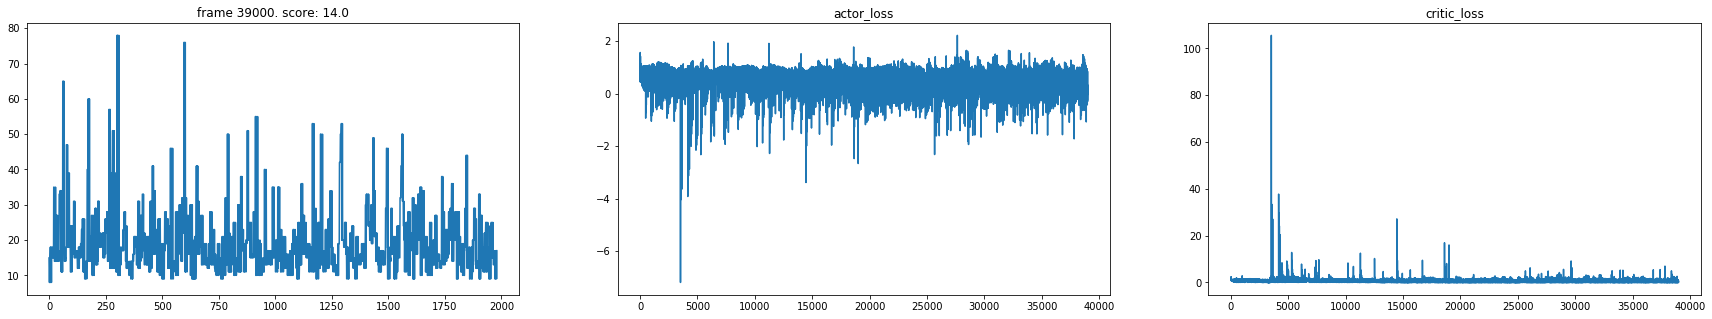

KeyboardInterrupt: 

In [26]:
agent.run_mp_training(num_frames)

In [18]:
frames = agent.test()

score:  12.0
